# Gan para generar prendas de ropa y accesorios

Para este proyecto usaremos el dataset que tiene por defecto *keras* el cual es `fasion_mnist`.

El objetivo será crear un generador de imágenes de prendas de ropas y accesorios, para ello entrenaremos una *red generativa adversaria*, donde un generador y un discriminador se entrenarán mutuamente para afinar el rendimiento.

## Importación de librerías

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

## Carga y muestra de las imágenes del dataset

### Crear constantes del dataset y modelo

Declarando las siguientes constantes conseguiremos que para aumentar el rendimiento del modelo sea mucho más sencillo, solo tendremos que modificar estos valores.

In [2]:
IMG_SIZE = (28, 28)
BATCH_SIZE = 32
NUMBER_OF_FILES = 70000
EPOCHS = 100
LATENT_DIM = 100 # Semilla del generador

Importaremos a continuación el dataset y normalizaremos los datos preparandolo para nuestro posterior entrenamiento.

In [3]:
# Importamos el dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Concatenamos los datos de entrenamiento y test en un solo array. 
# Los valores de y no nos interesan, por lo que no los concatenamos ni haremos nada con ellos
images = np.concatenate((X_train, X_test))

In [4]:
# Tendremos 70000 imagenes
print(images.shape)

(70000, 28, 28)


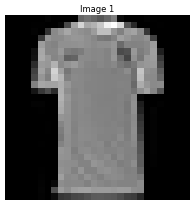

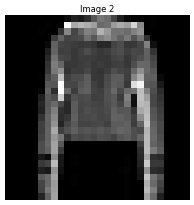

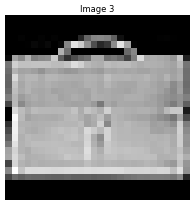

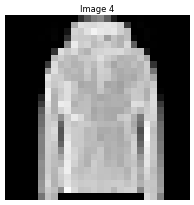

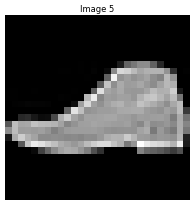

In [5]:
# Podemos mostrar algunas imagenes
sample_images = random.sample(list(images), 5)
count = 1
for image in sample_images:
    plt.figure(dpi=50)
    plt.title(f"Image {count}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    count+=1
    plt.show()

Lo que haremos es capar el número de imágenes que usaremos para el modelo, posteriormente cambiando las constantes de arriba podremos probar con un lote mayor.

In [6]:
images = images[:NUMBER_OF_FILES]

Ahora un paso importante que debemos de hacer es normalizar entre $-1$ y $1$, que es lo ideal para nuestro modelo de generación e inicializar el dataset de tensorflow.

In [7]:
dataset_images = images / 127.5 - 1.0
dataset_images = tf.expand_dims(dataset_images, -1) # Añadimos una dimensión para el canal de color
dataset_images = tf.data.Dataset.from_tensor_slices(dataset_images).shuffle(NUMBER_OF_FILES).batch(BATCH_SIZE)
print(f"Dataset procesado: {NUMBER_OF_FILES} imágenes cargadas y preparadas.")

Dataset procesado: 70000 imágenes cargadas y preparadas.


Vamos a verificar las dimensiones del lote:

In [8]:
for batch in dataset_images.take(1):
    print("Dimensiones del lote:", batch.shape)
    print(f"Rango: ({batch.numpy().min()} a {batch.numpy().max()})")

Dimensiones del lote: (32, 28, 28, 1)
Rango: (-1.0 a 1.0)


## Creación de la **GAN**

### Creación del Generador

In [9]:
generator = keras.Sequential([
    layers.Input(shape=(LATENT_DIM,), name="gen_input_layer"),

    layers.Dense(7*7*128, name="gen_first_dense_layer"),
    layers.BatchNormalization(name="gen_first_bn_layer"),
    layers.LeakyReLU(name="gen_first_leakyrelu_layer"),

    layers.Reshape((7, 7, 128), name="gen_reshape_layer"),

    # Primera capa convolucional transpuesta: de 7x7 a 14x14
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", activation="selu", name="gen_first_conv2d_layer"),
    layers.BatchNormalization(name="gen_second_bn_layer"),
    layers.LeakyReLU(name="gen_second_leakyrelu_layer"),

    # Segunda capa convolucional transpuesta, OUTPUT: de 14x14 a 28x28
    layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", activation="tanh", name="gen_second_conv2d_layer"),
])

generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gen_first_dense_layer (Dense)   │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_first_bn_layer              │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_first_leakyrelu_layer       │ (None, 6272)           │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_reshape_layer (Reshape)     │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_first_conv2d_layer          │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_second_bn_layer             │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_second_leakyrelu_layer      │ (None, 14, 14, 64)     │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gen_second_conv2d_layer         │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 865,281 (3.30 MB)

 Trainable params: 852,609 (3.25 MB)

 Non-trainable params: 12,672 (49.50 KB)

#### Probaremos el generador antes del entrenamiento

Primero de todos deberemos de crear ruido, que será lo que introduzcamos como entrada para generar las imágenes.

In [10]:
noise = tf.random.normal([1, LATENT_DIM])

Dimensiones de la imagen generada: (1, 28, 28, 1)
Rango de valores de la imagen generada: -0.13987648 - 0.12353628


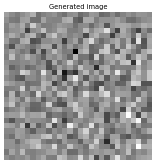

In [11]:
generated_image = generator(noise, training=False)
print("Dimensiones de la imagen generada:", generated_image.shape)
print("Rango de valores de la imagen generada:", generated_image.numpy().min(), "-", generated_image.numpy().max())
plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2, cmap="grey") # Reescala la imagen al rango [0, 1] para visualizarla 
plt.axis("off")
plt.title("Generated image")
plt.show()

### Creación del Descriminador

In [12]:
discriminator = keras.Sequential([
    layers.Input(shape=(28, 28, 1), name="dis_input_layer"),

    # Primera capa convolucional
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", name="dis_first_conv2d_layer"),
    layers.LeakyReLU(name="dis_first_leakyrelu_layer"),
    layers.Dropout(0.3, name="dis_first_dropout_layer"),

    # Segunda capa convolucional
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same", name="dis_second_conv2d_layer"),
    layers.LeakyReLU(name="dis_second_leakyrelu_layer"),
    layers.Dropout(0.3, name="dis_second_dropout_layer"),

    layers.Flatten(name="dis_flatten_layer"),
    layers.Dense(1, activation="sigmoid", name="dis_output_layer"),
])

discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dis_first_conv2d_layer (Conv2D) │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_first_leakyrelu_layer       │ (None, 14, 14, 64)     │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_first_dropout_layer         │ (None, 14, 14, 64)     │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_second_conv2d_layer         │ (None, 7, 7, 128)      │       204,928 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_second_leakyrelu_layer      │ (None, 7, 7, 128)      │             0 │
│ (LeakyReLU)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_second_dropout_layer        │ (None, 7, 7, 128)      │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_flatten_layer (Flatten)     │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_output_layer (Dense)        │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Comprobación del discriminador

In [13]:
decision = discriminator(generated_image)
print("Decision:", decision.numpy())

Decision: [[0.49877992]]


### Inicializar optimizadores y función de pérdida

In [14]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

### Entrenamiento de la GAN y carga de modelos

In [16]:
# Cargar el modelo desde local si existe, con la mayor epoca:

def load_latest_models(model_dir="models"):
    """Carga el ultimo modelo guardado si existe"""
    try:
        if not os.path.exists(model_dir):
            print(f"El directorio {model_dir} no existe.")
            return None, None, 0
         
        generator_files = [f for f in os.listdir(model_dir) if f.startswith("generador_fashion_")]
        if not generator_files:
            return None, None, 0
        
        # Parsear y extraer (época, imágenes) de los nombres
        file_info = []
        for file in generator_files:
            # Formato: generador_fashion_{epoch}ep_{imgCount}img.keras
            parts = file.split("_")  
            epoch_str = parts[2].replace("ep", "")
            img_str = parts[3].replace("img.keras", "")
            epoch = int(epoch_str)
            img_count = int(img_str)
            file_info.append((epoch, img_count, file))

        # Ordenar: primero por número de imágenes, luego por época, ambos descendentes
        file_info.sort(key=lambda x: (x[1], x[0]), reverse=True)
        best_epoch, highest_img_count, _ = file_info[0]

        # Cargar modelo
        generator = tf.keras.models.load_model(
            f"models/generador_fashion_{best_epoch}ep_{highest_img_count}img.keras"
        )
        discriminator = tf.keras.models.load_model(
            f"models/discriminador_fashion_{best_epoch}ep_{highest_img_count}img.keras"
        )

        return generator, discriminator, best_epoch
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        return None, None, 0

In [17]:
def train_gan(resume_epoch=0, epochs=EPOCHS):
    for epoch in tqdm(range(resume_epoch, epochs)):
        print(f"Época {epoch + 1}/{EPOCHS}...") 

        for real_images in dataset_images: 
            current_batch_size = real_images.shape[0]

            noise = tf.random.normal([current_batch_size, LATENT_DIM])

            generated_images = generator(noise, training=True)

            real_labels = tf.ones((current_batch_size, 1)) 
            false_labels = tf.zeros((current_batch_size, 1)) 

            with tf.GradientTape() as disc_tape: 
                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(generated_images, training=True)
                disc_loss_real = cross_entropy(real_labels, real_output)
                disc_loss_fake = cross_entropy(false_labels, fake_output)
                disc_loss = disc_loss_real + disc_loss_fake

            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            noise = tf.random.normal([current_batch_size, LATENT_DIM])

            with tf.GradientTape() as gen_tape: 
                generated_images = generator(noise, training=True)
                fake_output = discriminator(generated_images, training=False)
                gen_loss = cross_entropy(real_labels, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        print(f"Pérdida del discriminador: {disc_loss.numpy()}, Pérdida del generador: {gen_loss.numpy()}")

        if (epoch + 1) % 10 == 0 or epoch == EPOCHS - 1:
            noise = tf.random.normal([16, LATENT_DIM])
            generated_images = generator(noise, training=False)
            generated_images = (generated_images + 1) / 2 


            fig, axes = plt.subplots(4, 4, figsize=(6, 6))
            for img, ax in zip(generated_images, axes.flatten()):
                ax.imshow(img, cmap="gray")
                ax.axis("off")
            plt.show()

            os.makedirs("models", exist_ok=True)
            generator.save(f"models/generador_fashion_{epoch+1}ep_{NUMBER_OF_FILES}img.keras")
            discriminator.save(f"models/discriminador_fashion_{epoch+1}ep_{NUMBER_OF_FILES}img.keras")

In [22]:
# Entrenamiento de la GAN
generator_loaded, discriminator_loaded, highest_epoch = load_latest_models("models")

if generator_loaded is not None and discriminator_loaded is not None and highest_epoch >= EPOCHS:
    print(f"Modelos cargados de la época {highest_epoch}. Entrenamiento ya completado.")
    generator = generator_loaded
    discriminator = discriminator_loaded
elif generator_loaded is not None and discriminator_loaded is not None:
    print(f"Modelos cargados de la época {highest_epoch}. Continuando con el entrenamiento...")
    # Hacer un entrenamiento desde la epoca que estuviera hasta la epoca deseada
    generator = generator_loaded
    discriminator = discriminator_loaded
    train_gan(resume_epoch=highest_epoch, epochs=EPOCHS)
else:
    print(f"No se han encontrado modelos de forma local, continuaremos con un modelo desde cero...")
    # Hacer el entrenamiento desde cero
    train_gan(resume_epoch=0, epochs=EPOCHS)

Modelos cargados de la época 100. Entrenamiento ya completado.


#### Probar el generador cargado

Dimensiones de la imagen generada: (1, 28, 28, 1)
Rango de valores de la imagen generada: -1.0 - 0.9373537


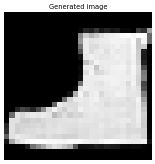

In [23]:
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

print("Dimensiones de la imagen generada:", generated_image.shape)
print("Rango de valores de la imagen generada:", generated_image.numpy().min(), "-", generated_image.numpy().max())

plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2, cmap="gray") 
plt.axis("off")
plt.title("Generated image")
plt.show()

Por último, generaremos 100 imágenes de muestra para tener una aproximación de qué tan optimizado es nuestro modelo.

In [26]:
number_of_sample_images = 100

for i in range(number_of_sample_images):
    noise = tf.random.normal([1, LATENT_DIM])
    generated_image = generator(noise, training=False)
    generated_image = (generated_image + 1) / 2
    plt.figure(dpi=50)
    os.makedirs("samples_generated", exist_ok=True)
    plt.imsave(fname=f"samples_generated/image_{i + 1}.png", arr=tf.squeeze(generated_image[0]).numpy(), cmap="gray")

C:\Users\alfre\AppData\Local\Temp\ipykernel_15072\2558714593.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(dpi=50)


<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>

<Figure size 320x240 with 0 Axes>